

# Introduction

This notebook explores the housing market in London between 1995 and 2019, using exploratory data analysis. My aim is to uncover new information and answer the following questions:

- How has the housing market (average house price and number of houses sold) changed over time in different boroughs of London? How does it compare to the housing market in England?
- What are the most significant factors that have influenced the housing market?
- What ML models are able to predict the housing market?

## Table of Contents

This notebook is organized into the following sections:

1. Introduction
2. Libraries
3. Datasets
4. Data preparation
5. Housing over the Years
6. Factors Affecting Housing
7. Conclusions
8. Future Developments

# Libraries

In this section, I will import the necessary libraries for our analysis.

In [10]:
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
import geopandas as gpd
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
import seaborn as sns
from IPython.display import HTML
import warnings
warnings.filterwarnings('ignore')
import plotly.express as px

hfont = {'fontname':'Helvetica'}
csfont = {'fontname':'Futura'}


# Datasets

For this project I will use the:
- [Housing in London](https://www.kaggle.com/justinas/housing-in-london) dataset which is provided by [Justinas Cirtautas](https://www.kaggle.com/justinas). It contains two csv files ('**housing_in_london_monthly_variables.csv**' and '**housing_in_london_yearly_variables.csv'**) with a lot of relevant information such as the monthly average house prices, yearly mean and median salary for residents of each area, etc.
- [London Borough and Ward Boundaries up to 2014](https://www.kaggle.com/csobral/london-borough-and-ward-boundaries-up-to-2014/notebooks) dataset, provided by [Cayo Costa Sobral](https://www.kaggle.com/csobral). It contains a shapefile with the boundaries of the London boroughs and wards.

# Data preparation

In this section, I will load the datasets and perform some preprocessing steps.

In [15]:
# Read the data
london_monthly = pd.read_csv('housing_in_london_monthly_variables.csv', parse_dates = ['date'])
# Print the first five rows of the dataset
print ('This dataset contains {} rows and {} columns.'.format(london_monthly.shape[0], london_monthly.shape[1]))
london_monthly.head()

This dataset contains 13549 rows and 7 columns.


,date,area,average_price,code,houses_sold,no_of_crimes,borough_flag
0,1995-01-01,city of london,91449,E09000001,17.0,NaN,1
1,1995-02-01,city of london,82203,E09000001,7.0,NaN,1
2,1995-03-01,city of london,79121,E09000001,14.0,NaN,1
3,1995-04-01,city of london,77101,E09000001,7.0,NaN,1
4,1995-05-01,city of london,84409,E09000001,10.0,NaN,1


There are 7 attributes in the dataset: 
- `date`: the date of the observation
- `area`: the name of the area
- `average_price`: the average price of the houses sold in the area
- `code`: the code of the area
- `houses_sold`: the number of houses sold in the area
- `no_of_crimes`: the number of crimes in the area
- `borough_flag`: a flag indicating whether the area is a borough or not



In [16]:
# Print the data types of each column
london_monthly.info()

# Print the number of missing values in each column
london_monthly_zero = london_monthly.isnull().sum().sort_values(ascending = False)
percent = (london_monthly.isnull().sum()/london_monthly.isnull().count()).sort_values(ascending = False)*100
london_monthly_zero = pd.concat([london_monthly_zero, percent], axis = 1, keys = ['Counts', '% Missing'])
print ('These columns have missing data: ')
london_monthly_zero.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13549 entries, 0 to 13548
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           13549 non-null  datetime64[ns]
 1   area           13549 non-null  object        
 2   average_price  13549 non-null  int64         
 3   code           13549 non-null  object        
 4   houses_sold    13455 non-null  float64       
 5   no_of_crimes   7439 non-null   float64       
 6   borough_flag   13549 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(2), object(2)
memory usage: 741.1+ KB
These columns have missing data: 


,Counts,% Missing
no_of_crimes,6110,45.095579
houses_sold,94,0.693778
date,0,0.000000
area,0,0.000000
average_price,0,0.000000


As we can see, the dataset contains a lot of missing values. For the `houses_sold` column, I will fill the missing values with the mean of the particular area. I will also drop the `no_of_crimes` column as it contains too many missing values. 
Additionally I will add a new column `year` which will contain the year of the observation. And I will drop the value 2020 from the `year` column as it is not a complete year. 

In [17]:
# get rid off the 'no_of_crimes' column
london_monthly.drop('no_of_crimes', axis = 1, inplace = True)   

# Fill the missing values in the 'houses_sold' column with the mean of the area
london_monthly['houses_sold'].fillna(london_monthly.groupby('area')['houses_sold'].transform('mean'), inplace = True)

# Extract the year from the date column
london_monthly['year'] = london_monthly['date'].dt.year
london_monthly.iloc[[0, -1]]

# discard the data from 2020, because year not complete
london_monthly = london_monthly[london_monthly['year'] < 2020]

# Check the max value of the year column (should be 2019)
london_monthly['year'].max()

2019

## London Map   

I will use the 'London Borough and Ward Boundaries' dataset to plot the map of London, with respective borough boundaries. 

: 

: 

## Data Exploration

According to [Wikipedia](https://en.wikipedia.org/wiki/List_of_London_boroughs), there are 33 boroughs in London (32 + the City of London). Is that the case in our dataset? And what are the names of the boroughs?

In [18]:
london_boroughs = london_monthly[london_monthly['borough_flag'] == 1]['area'].unique()
len(london_boroughs)

# What are 33 London boroughs? Let's print them with a loop. 
for i, name in enumerate(london_boroughs):
  print(i+1,':', name)

1 : city of london
2 : barking and dagenham
3 : barnet
4 : bexley
5 : brent
6 : bromley
7 : camden
8 : croydon
9 : ealing
10 : enfield
11 : tower hamlets
12 : greenwich
13 : hackney
14 : hammersmith and fulham
15 : haringey
16 : harrow
17 : havering
18 : hillingdon
19 : hounslow
20 : islington
21 : kensington and chelsea
22 : kingston upon thames
23 : lambeth
24 : lewisham
25 : merton
26 : newham
27 : redbridge
28 : richmond upon thames
29 : southwark
30 : sutton
31 : waltham forest
32 : wandsworth
33 : westminster


It is! How many and which regions are outside of London?

In [19]:
london_monthly[london_monthly['borough_flag'] == 0]['area'].nunique()

12

In [20]:
london_monthly[london_monthly['borough_flag'] == 0]['area'].unique()

array(['south east', 'inner london', 'outer london', 'north east',
       'north west', 'yorks and the humber', 'east midlands',
       'west midlands', 'east of england', 'london', 'south west',
       'england'], dtype=object)

We can manually isolate the ones that correspond to a region in England: 

In [21]:
england_regions = ['south west', 'south east', 'east of england', 'west midlands', 'east midlands', 'yorks and the humber', 'north west', 'north east']

### London VS England

We can now split the dataset into two: one for boroughs in London and one for the other regions of England:

In [22]:
london = london_monthly[london_monthly['area'].isin(london_boroughs)]
england = london_monthly[london_monthly['area'].isin(england_regions)]

#### Average Price

The `groupby()` method allows us to calculate the mean 'average price' for each 'date':

In [23]:
london_price = london.groupby('date')['average_price'].mean()
england_price = england.groupby('date')['average_price'].mean()

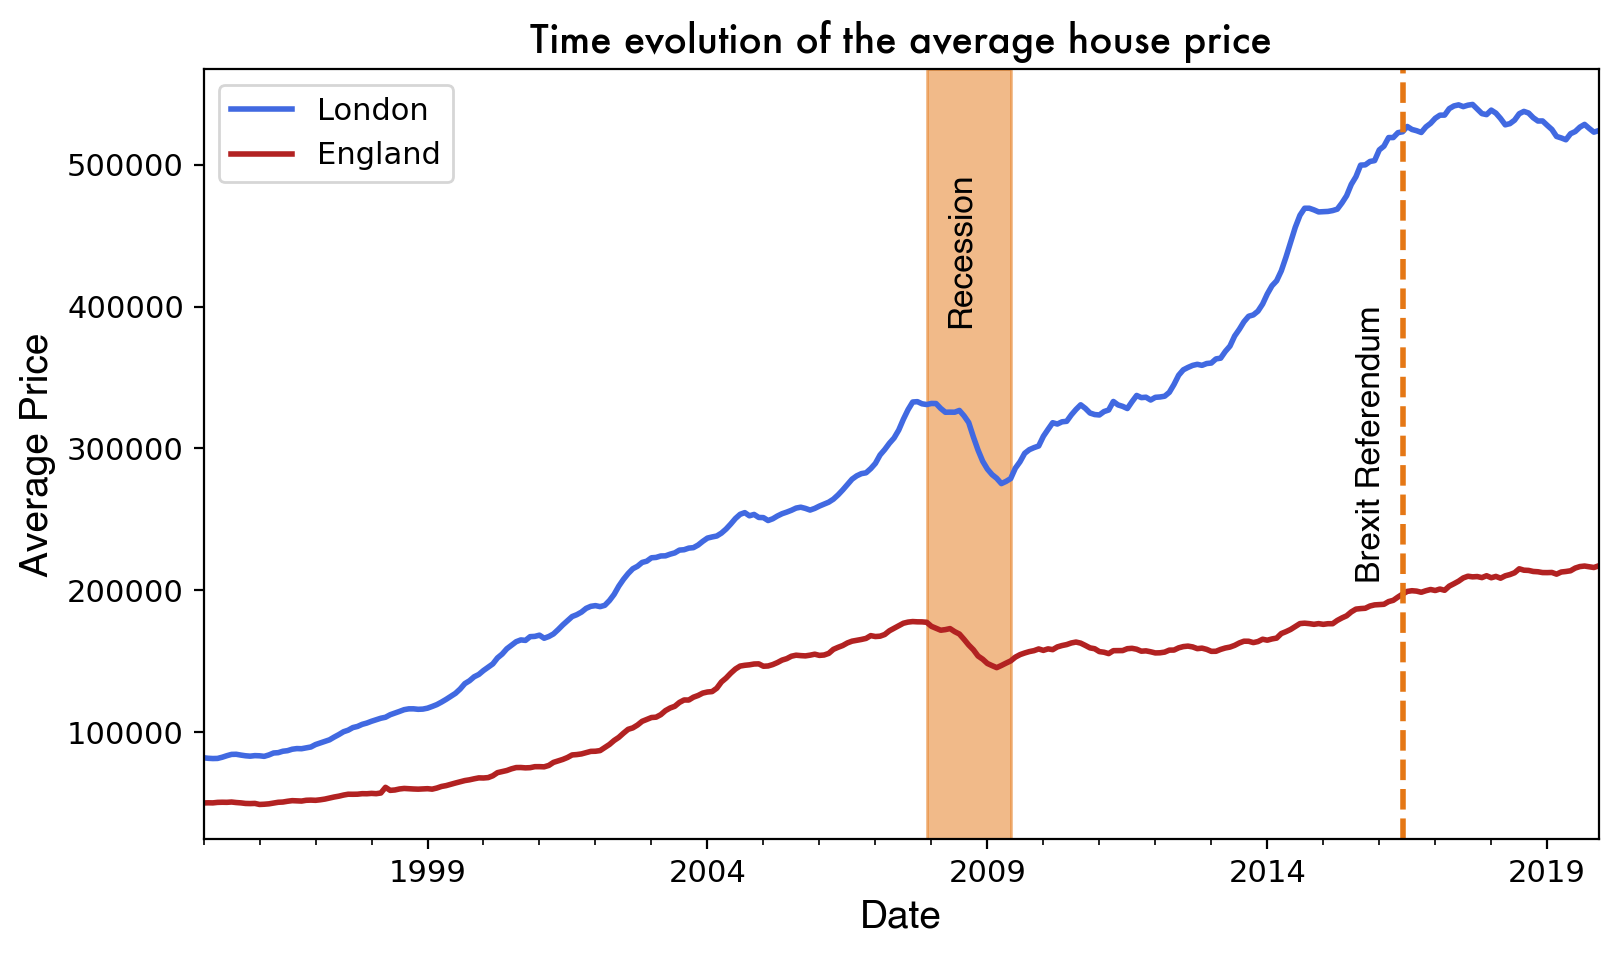

In [24]:
plt.figure(figsize = (9, 5))

font_size = 14
london_price.plot(y = 'average_price', color = 'royalblue', lw = 2, label = 'London')
england_price.plot(y = 'average_price', color = 'firebrick', lw = 2, label = 'England')

plt.axvspan('2007-12-21', '2009-06-21', alpha = 0.5, color = '#E57715')
plt.text(x = '2008-04-01', y = 390000, s = 'Recession', rotation = 90, fontsize = font_size-2, **hfont)
plt.axvline(x = '2016-06-23', lw = 2, color = '#E57715', linestyle = '--')
plt.text(x = '2015-08-01', y = 210000, s = 'Brexit Referendum', rotation = 90, fontsize = font_size-2, **hfont)

plt.title('Time evolution of the average house price', size = font_size, **csfont)
plt.ylabel('Average Price', size = font_size, **hfont)
plt.xticks(size = font_size - 3)
plt.xlabel('Date', size = font_size, **hfont)
plt.yticks(size = font_size - 3)
plt.legend(fontsize = font_size - 3)
plt.show()

# Was having trouble with Matplot for the following plots, so I switched to Plotly
fig = px.box(london_monthly, x="average_price", template='simple_white', title='Average house price (1995 - 2020)',
             width=700, height=500, color='borough_flag')

fig.update_layout(title_font_family='Futura', xaxis=dict(title_font_family='Futura'), yaxis=dict(title_font_family='Futura'))

fig.show()

- In overall, the averace price follows an **upward trend** during the studied time frame, with London always having a higher average price. 
- This upward trend was disrupted by the the **[Great Recession](https://en.wikipedia.org/wiki/Great_Recession)** (2007-209), hence the significant **decline starting from 2007**. London apparently **recovered quickly** and the average price increased rapidly until 2016. **England** followed a similar behaviour but with a **moderate rise** in the same period.
- Arguably, the **[Brexit referendum](https://en.wikipedia.org/wiki/2016_United_Kingdom_European_Union_membership_referendum)** had an impact in London housing since the average price hit a **plateau after 2016**. It seems the the rest of England wasn't affected as much from the referendum.



<br>

The average price in each borough fluctuates through time. However, we can calculate its mean which can give us a rough indication of how expensive each area is.

In [25]:
london_borough_prices = london.groupby('area')['average_price'].mean()
london_top10_prices = london_borough_prices.sort_values(ascending = False).to_frame()

print ('\nThe 10 most expensive boroughs in London are:')
london_top10_prices.head(10)


The 10 most expensive boroughs in London are:


,average_price
area,
kensington and chelsea,740606.683333
westminster,542282.063333
camden,466358.253333
hammersmith and fulham,442773.376667
city of london,422771.363333
richmond upon thames,381640.966667
islington,364160.283333
wandsworth,341411.026667
barnet,304272.120000


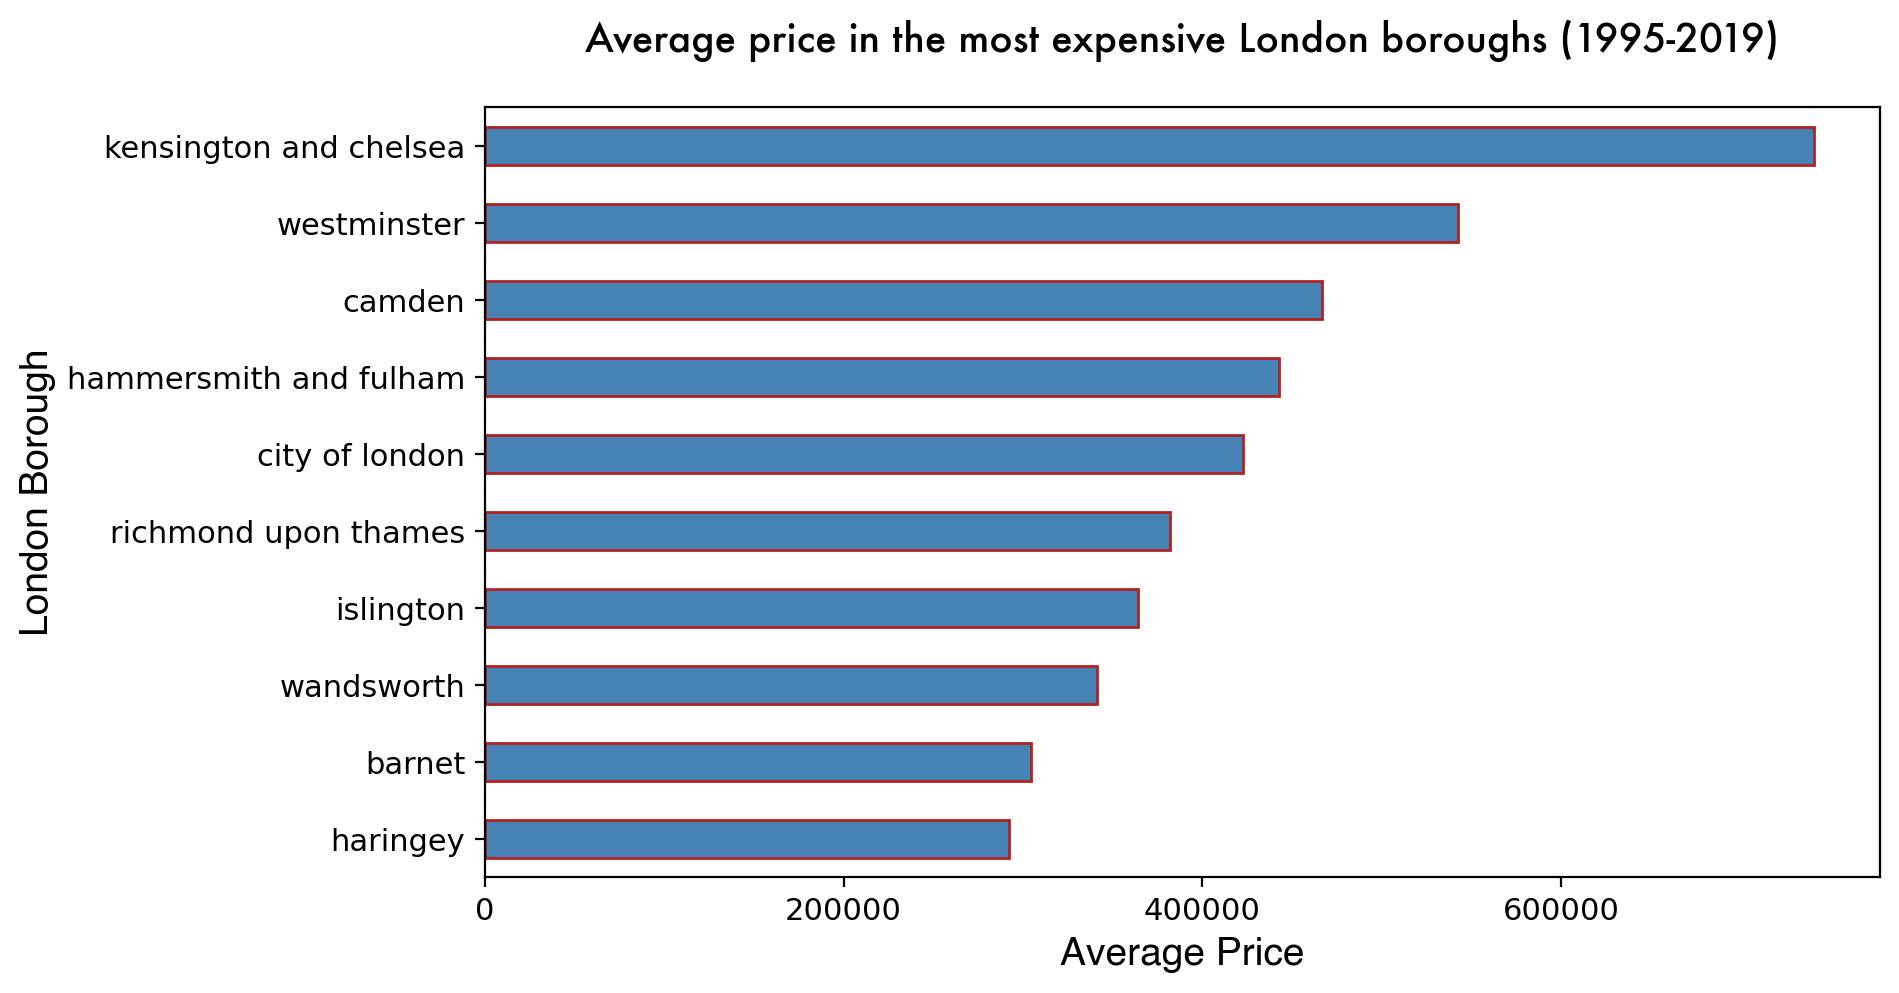

In [26]:
london_top10_prices.head(10).sort_values(by = 'average_price', ascending = True).plot(kind = 'barh', figsize = (9, 5), 
                                                                               color = 'steelblue', edgecolor = 'firebrick',
                                                                               legend = False)

plt.title('Average price in the most expensive London boroughs (1995-2019)', size = font_size, y = 1.05, **csfont)
plt.ylabel('London Borough', size = font_size, **hfont)
plt.yticks(size = font_size - 3)
plt.xlabel('Average Price', size = font_size, **hfont)
plt.xticks([0, 200_000, 400_000, 600_000], size = font_size - 3);

We focus on the 5 most expensive boroughs and see the evolution of the average price through time:

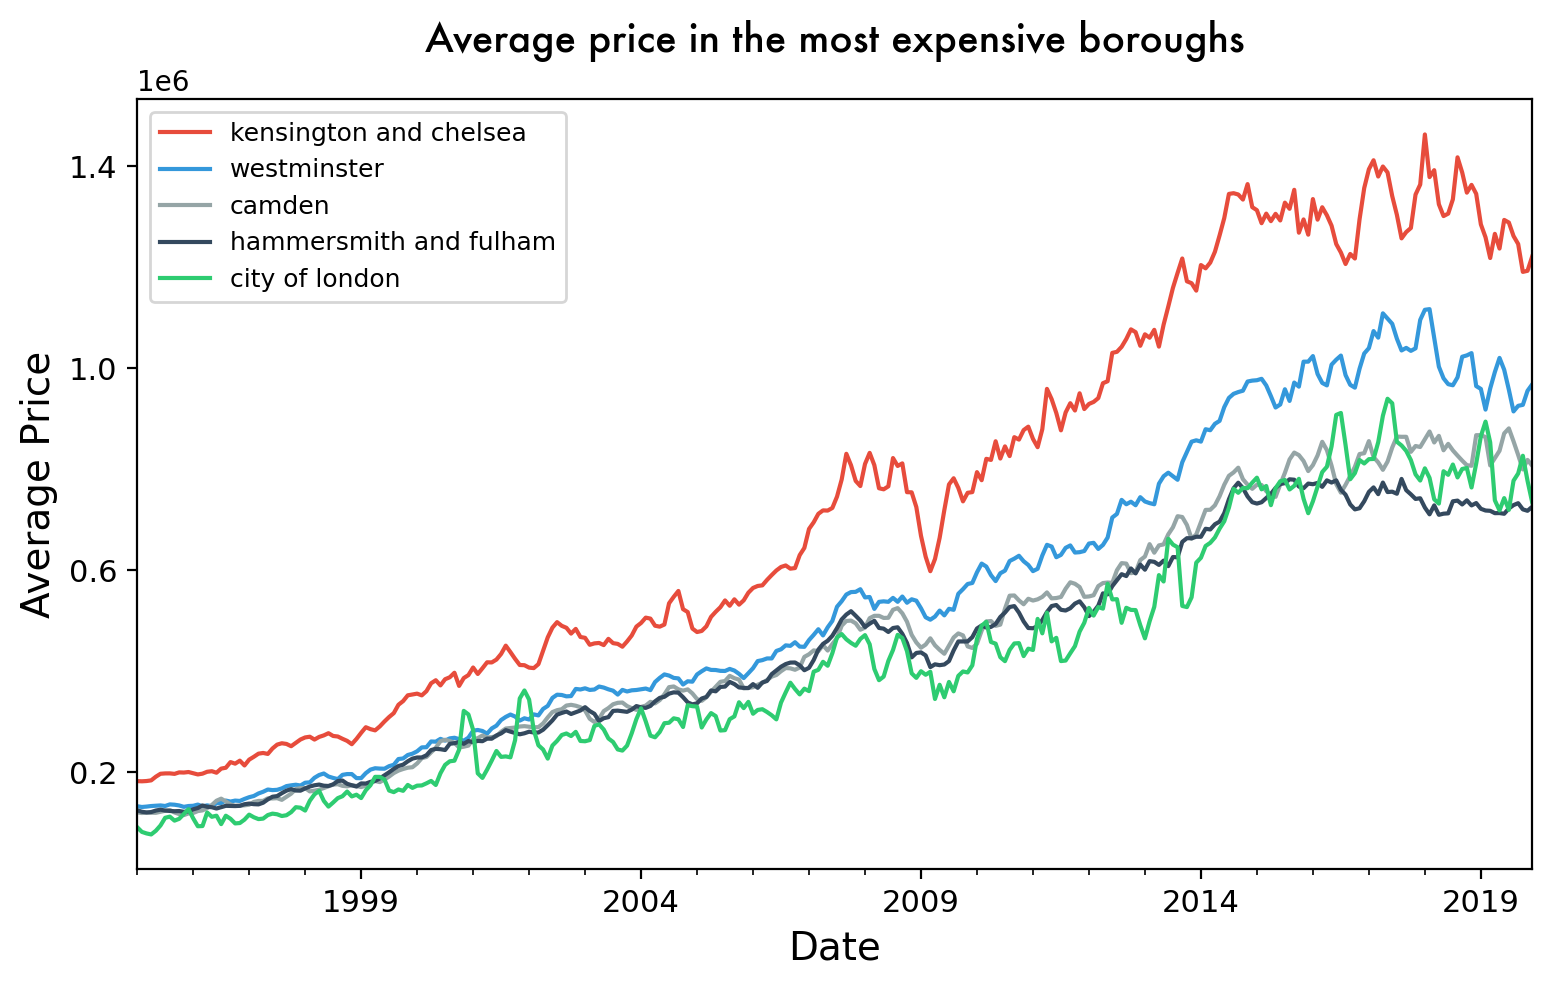

In [27]:
top5_indeces = london_top10_prices.head().index
colors = ['#e74c3c', '#3498db', '#95a5a6', '#34495e', '#2ecc71']

plt.figure(figsize = (9, 5))

for index, i in enumerate(top5_indeces):
    df = london[london['area'] == i]
    df = df.groupby('date')['average_price'].mean()
    
    df.plot(y = 'average_price', label = i, color = colors[index])
       
plt.title('Average price in the most expensive boroughs', y = 1.04, size = font_size, **csfont)
plt.xlabel('Date', size = font_size)
plt.xticks(size = font_size - 3)
plt.ylabel('Average Price', size = font_size)
plt.yticks([0.2*1E+6, 0.6*1E+6, 1.0*1E+6, 1.4*1E+6], size = font_size - 3)
plt.legend(fontsize = font_size - 5);

- **Kensington and Chelsea** is the **most expensive borough** in London between 1995 and 2019. We can read in [wikipedia](https://en.wikipedia.org/wiki/Royal_Borough_of_Kensington_and_Chelsea) that it holds royal status and it includes many affluent areas, hence the increased price.
- **Westministe**r, which is adjacent to Kensighton, comes **second**. Again this is not a surpise since it is the location of the national government and includes many sites commonly associated with London (e.g. the Buckingham Palace, the Houses of Parliament, 10 Downing Street, and Trafalgar Square) ([Source](https://en.wikipedia.org/wiki/City_of_Westminster)).

We can perform a similar analysis for England:

In [28]:
england_prices = england.groupby('area')['average_price'].mean()
england_top3_prices = england_prices.sort_values(ascending = False).to_frame()

print('The top 3 most expensive regions in England are:')
england_top3_prices.head(3)

The top 3 most expensive regions in England are:


,average_price
area,
south east,195653.013289
east of england,170796.173333
south west,163050.030000


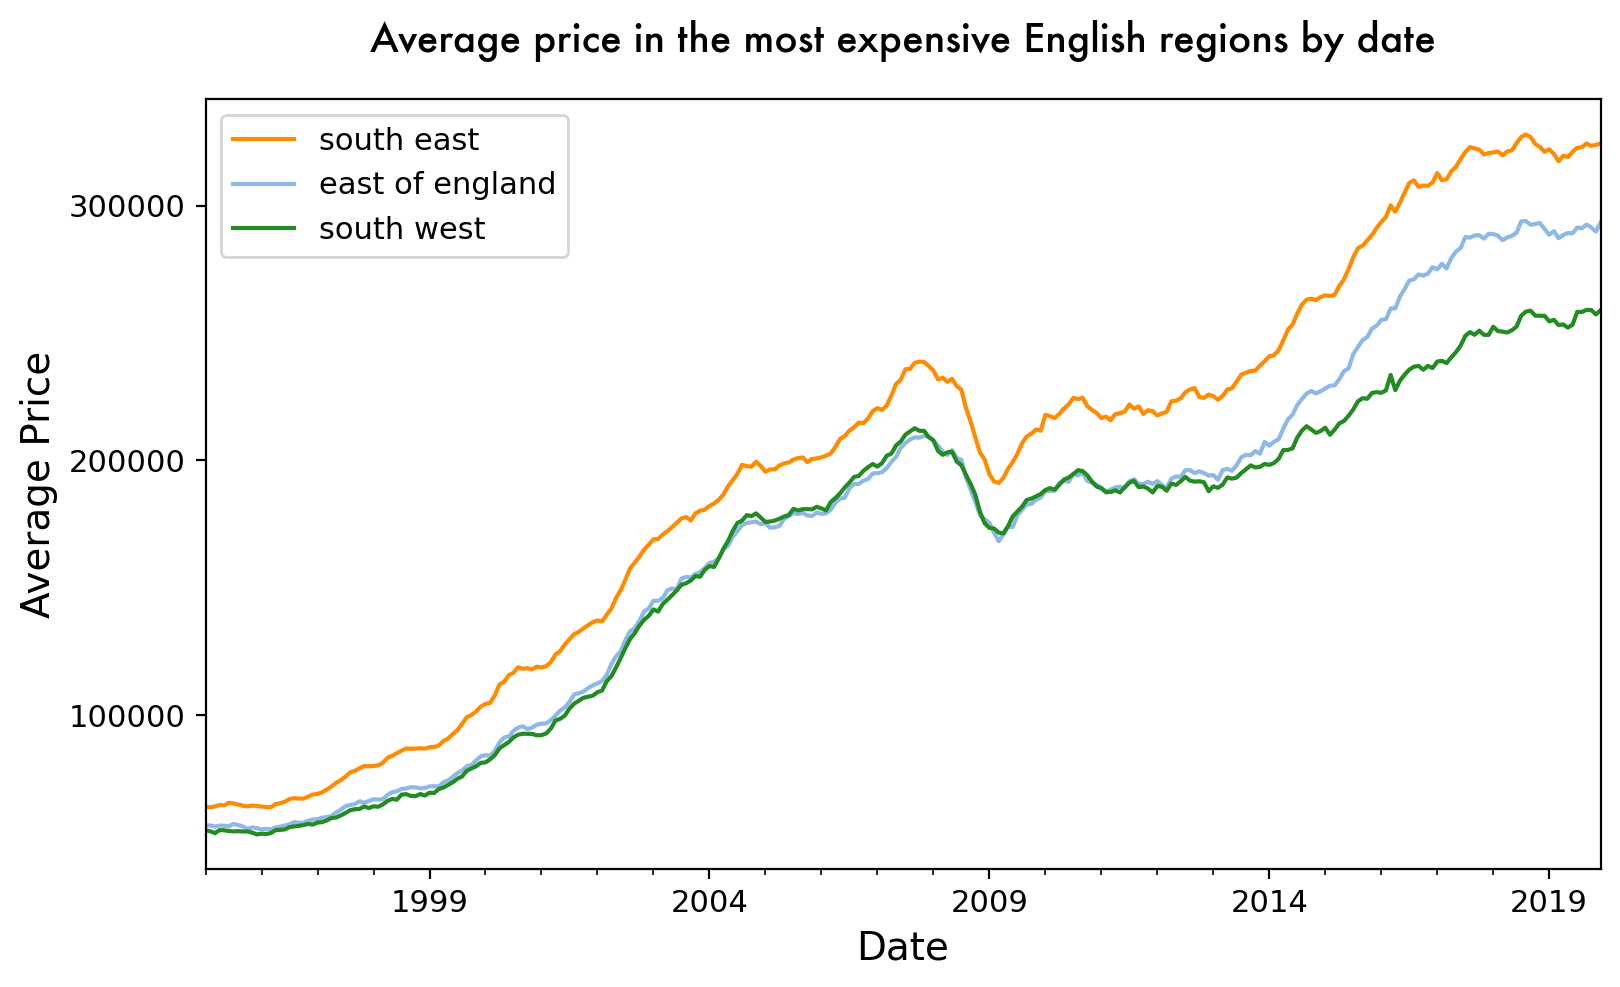

In [29]:
top3_indeces = england_top3_prices.head(3).index
colors = ['darkorange', '#8EB8E5', 'forestgreen', ]

plt.figure(figsize = (9, 5))

for index, i in enumerate(top3_indeces):
    df = england[england['area'] == i]
    df = df.groupby('date')['average_price'].mean()
    df.plot(y = 'average_price', label = i, color = colors[index])

plt.title('Average price in the most expensive English regions by date', size = font_size, y = 1.04, **csfont)
plt.xlabel('Date', size = font_size)
plt.xticks(size = font_size - 3)
plt.ylabel('Average Price', size = font_size)
plt.yticks([100_000, 200_000, 300_000], size = font_size - 3)
plt.legend(fontsize = font_size - 3);

The three **most expensive English regions** are all located in the **South of England** (two of them border London). It would be interesting to plot the same graph but with the cheapest borough of London (which we can find is Barking and Dagenham):

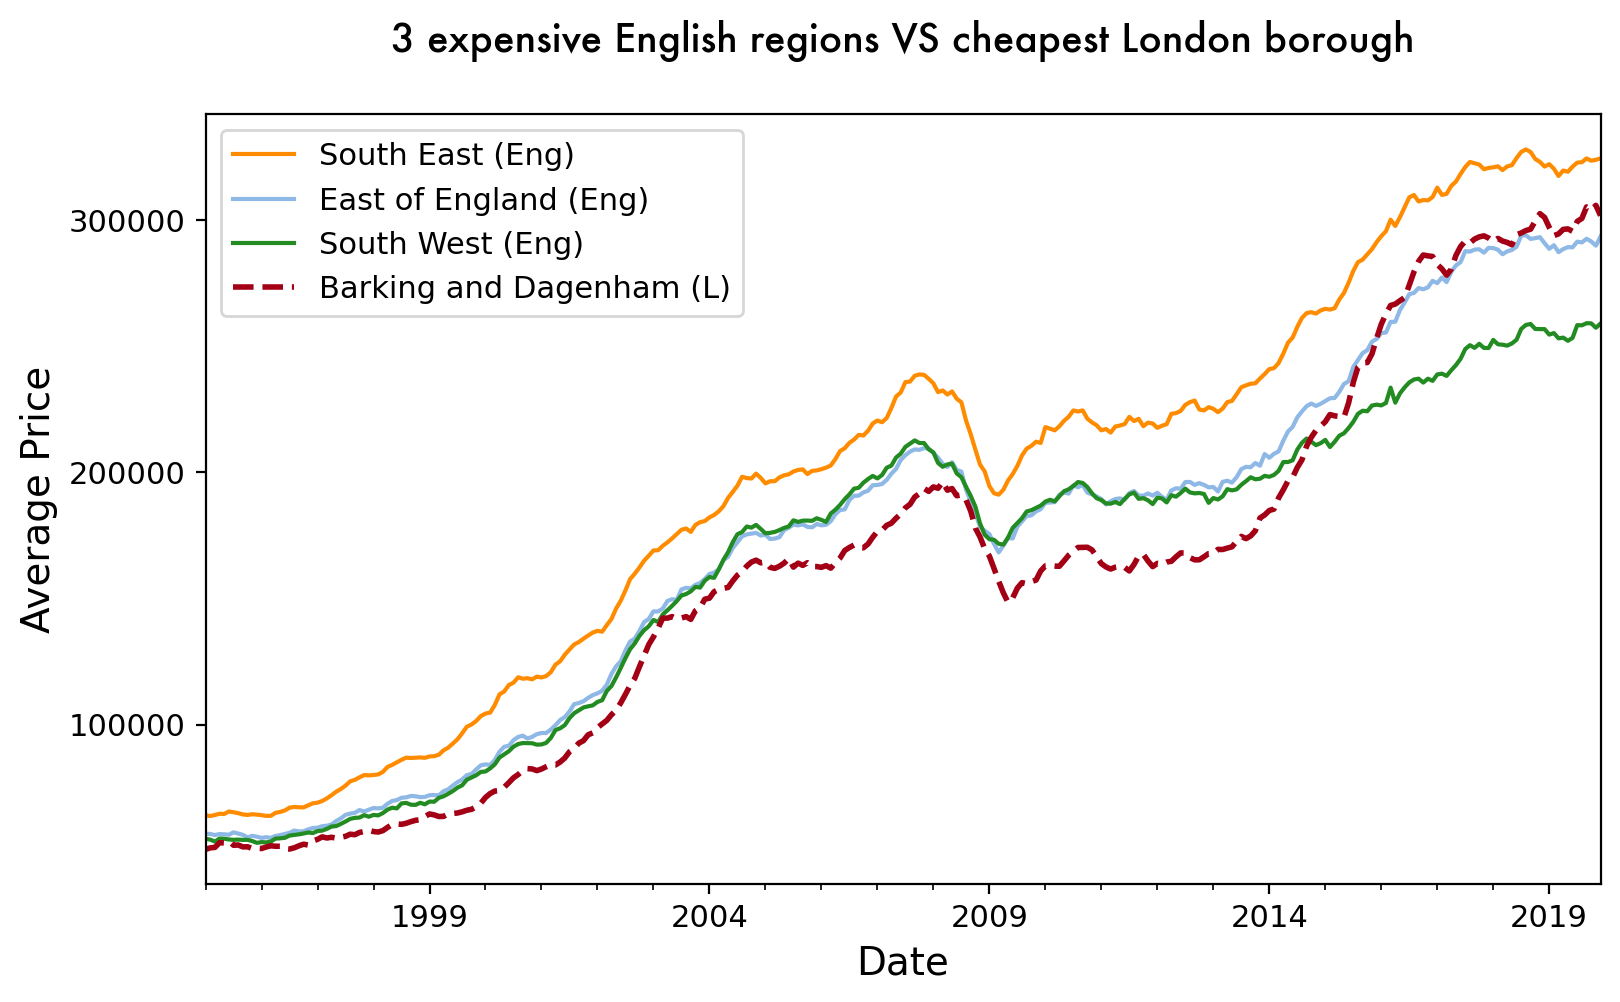

In [30]:
plt.figure(figsize = (9, 5))

for index, i in enumerate(top3_indeces):
    df_ = england[england['area'] == i]
    df_ = df_.groupby('date')['average_price'].mean()
    df_.plot(y = 'average_price', label = i, color = colors[index])

london_bng_pr = london[london['area'] == 'barking and dagenham'].groupby('date')['average_price'].mean()
london_bng_pr.plot(y = 'average_price', lw = 2, linestyle = '--', color = '#A30015', label = 'barking and dagenham')

plt.title('3 expensive English regions VS cheapest London borough', size = font_size, y = 1.06, **csfont)
plt.xlabel('Date', size = font_size)
plt.xticks(size = font_size - 3)
plt.ylabel('Average Price', size = font_size)
plt.yticks([0.1*1E+6, 0.2*1E+6, 0.3*1E+6], size = font_size - 3)
plt.legend(labels = ['South East (Eng)', 'East of England (Eng)', 'South West (Eng)', 'Barking and Dagenham (L)'], 
           fontsize = font_size - 3);

It is evident that even the cheapest borough in London is **comparable** to the most expensive regions of England!

### Houses Sold

Let's explore the 'houses_sold' attribute for London.

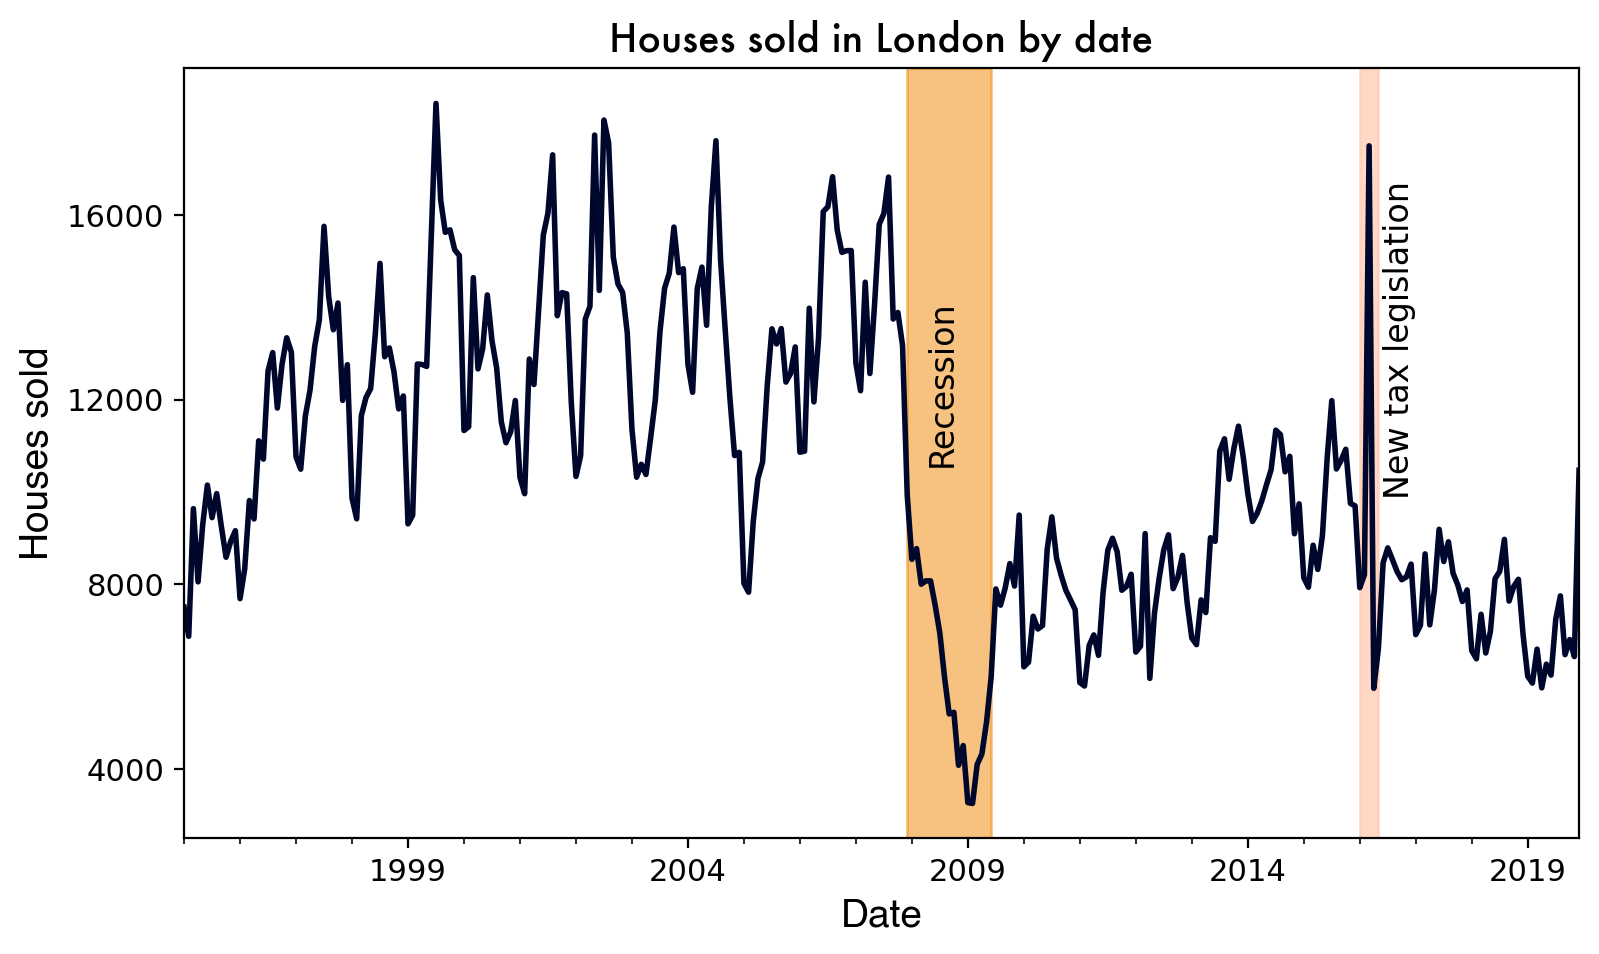

In [31]:
london_houses = london.groupby('date')['houses_sold'].sum()
london_houses.plot(figsize = (9, 5), lw = 2, y = 'houses_sold', color = '#00072D')

plt.axvspan('2007-12-21', '2009-06-21', alpha = 0.5, color = '#F08700')
plt.text(x = '2008-04-01', y = 10700, s = 'Recession', rotation = 90, fontsize = font_size-2)
plt.axvspan('2016-01-1', '2016-05-01', alpha = 0.7, color = '#FFCAAF')

# plt.axvline(x = '2016-06-23', lw = 2, color = '#E57715', linestyle = '--')
plt.text(x = '2016-06-01', y = 10000, s = 'New tax legislation', rotation = 90, fontsize = font_size-2)

plt.title('Houses sold in London by date', size = font_size, **csfont)
plt.xlabel('Date', size = font_size, **hfont)
plt.xticks(size = font_size - 3)
plt.ylabel('Houses sold', size = font_size, **hfont)
plt.yticks([4000, 8000, 12000, 16000], size = font_size - 3);

- The number of houses sold in London **dropped sharply** during the **financial recession** and it seems that it **hasn't completely recovered** since,  
- Interestingly, there is **spike in March 2016** which at first sight looks like a artefact. That is not the case, because people were actually trying to avoid a **new legislation** that came into effect in April 2016 and imposed an increase in the tax bill on buying a second home (Credits to [Marcel Fellipe](https://www.kaggle.com/marcelfellipe/housing-in-london-exploratory-data-analysis) for finding this). 
- Again, the **referendum** resulted in a **downward trend** starting from July 2016.

<br>

The boroughs with the highest number of sold houses between 1995 and 2019 are:

In [32]:
london_borough_houses = london.groupby('area')['houses_sold'].sum()
london_top5_houses = london_borough_houses.sort_values(ascending = False).to_frame()
london_top5_houses.head(5)

,houses_sold
area,
wandsworth,164419.063545
bromley,149012.709030
croydon,146393.979933
barnet,134094.983278
lambeth,118347.491639


To better understand these numbers we need more information such as the size of the borough, its population, crime rates etc. Some of these information are available in the other dataset ('housing_in_london_yearly_variables').

## Map of London

We are going to use the **second dataset** which contains geospatial information about London (specifically, the 'geometry' attribute). This [notebook](https://www.kaggle.com/justinas/house-prices-in-london) helped me a lot for the analysis.

We start by merging the two datasets:

In [42]:

import geopandas as gpd

# Read the shapefile data into a GeoDataFrame using pyogrio
london_map = gpd.read_file('London_Wards/Boroughs/London_Borough_Excluding_MHW.shp')

# Convert the column names to lowercase
london_map.columns = london_map.columns.str.lower()

# Print the first few rows of the GeoDataFrame
print(london_map.head()) 

                   name   gss_code   hectares  nonld_area ons_inner sub_2009  \
0  Kingston upon Thames  E09000021   3726.117       0.000         F     None   
1               Croydon  E09000008   8649.441       0.000         F     None   
2               Bromley  E09000006  15013.487       0.000         F     None   
3              Hounslow  E09000018   5658.541      60.755         F     None   
4                Ealing  E09000009   5554.428       0.000         F     None   

  sub_2006                                           geometry  
0     None  POLYGON ((516401.600 160201.800, 516407.300 16...  
1     None  POLYGON ((535009.200 159504.700, 535005.500 15...  
2     None  POLYGON ((540373.600 157530.400, 540361.200 15...  
3     None  POLYGON ((521975.800 178100.000, 521967.700 17...  
4     None  POLYGON ((510253.500 182881.600, 510249.900 18...  


In [43]:
london_map['name'] = london_map['name'].str.lower()
london_map.rename(columns = {'name': 'area'}, inplace = True)
london_map.rename(columns = {'gss_code': 'code'}, inplace = True)

london_map = london_map[['area', 'code', 'hectares', 'geometry']]
london_map.head()

,area,code,hectares,geometry
0,kingston upon thames,E09000021,3726.117,"POLYGON ((516401.600 160201.800, 516407.300 16..."
1,croydon,E09000008,8649.441,"POLYGON ((535009.200 159504.700, 535005.500 15..."
2,bromley,E09000006,15013.487,"POLYGON ((540373.600 157530.400, 540361.200 15..."
3,hounslow,E09000018,5658.541,"POLYGON ((521975.800 178100.000, 521967.700 17..."
4,ealing,E09000009,5554.428,"POLYGON ((510253.500 182881.600, 510249.900 18..."


In [44]:
london_map_2 = london.groupby('area').agg({'average_price': ['mean'], 'houses_sold': 'sum'})

london_map_2.columns = ['average_price', 'houses_sold']
london_map_2.reset_index(inplace = True)
london_map_2.head()

,area,average_price,houses_sold
0,barking and dagenham,159382.250000,59696.989967
1,barnet,304272.120000,134094.983278
2,bexley,189097.030000,97676.588629
3,brent,269830.480000,81885.953177
4,bromley,253551.966667,149012.709030


Remember that London has 33 boroughs. Let's check that the london_map dataset has the same names:

In [45]:
np.intersect1d(london_map['area'], london_map_2['area']).size

33

And it does! We can now merge the map data with the housing dataset:

In [46]:
london_map = pd.merge(london_map, london_map_2, how = 'inner', on = ['area'])
london_map.head()

,area,code,hectares,geometry,average_price,houses_sold
0,kingston upon thames,E09000021,3726.117,"POLYGON ((516401.600 160201.800, 516407.300 16...",281016.553333,75879.933110
1,croydon,E09000008,8649.441,"POLYGON ((535009.200 159504.700, 535005.500 15...",208818.630000,146393.979933
2,bromley,E09000006,15013.487,"POLYGON ((540373.600 157530.400, 540361.200 15...",253551.966667,149012.709030
3,hounslow,E09000018,5658.541,"POLYGON ((521975.800 178100.000, 521967.700 17...",235377.466667,85757.859532
4,ealing,E09000009,5554.428,"POLYGON ((510253.500 182881.600, 510249.900 18...",273874.886667,110410.033445


In [47]:
type(london_map)

geopandas.geodataframe.GeoDataFrame

The new dataset is london_map and is now a GeoDataFrame. Let's plot it using Ggplot. 

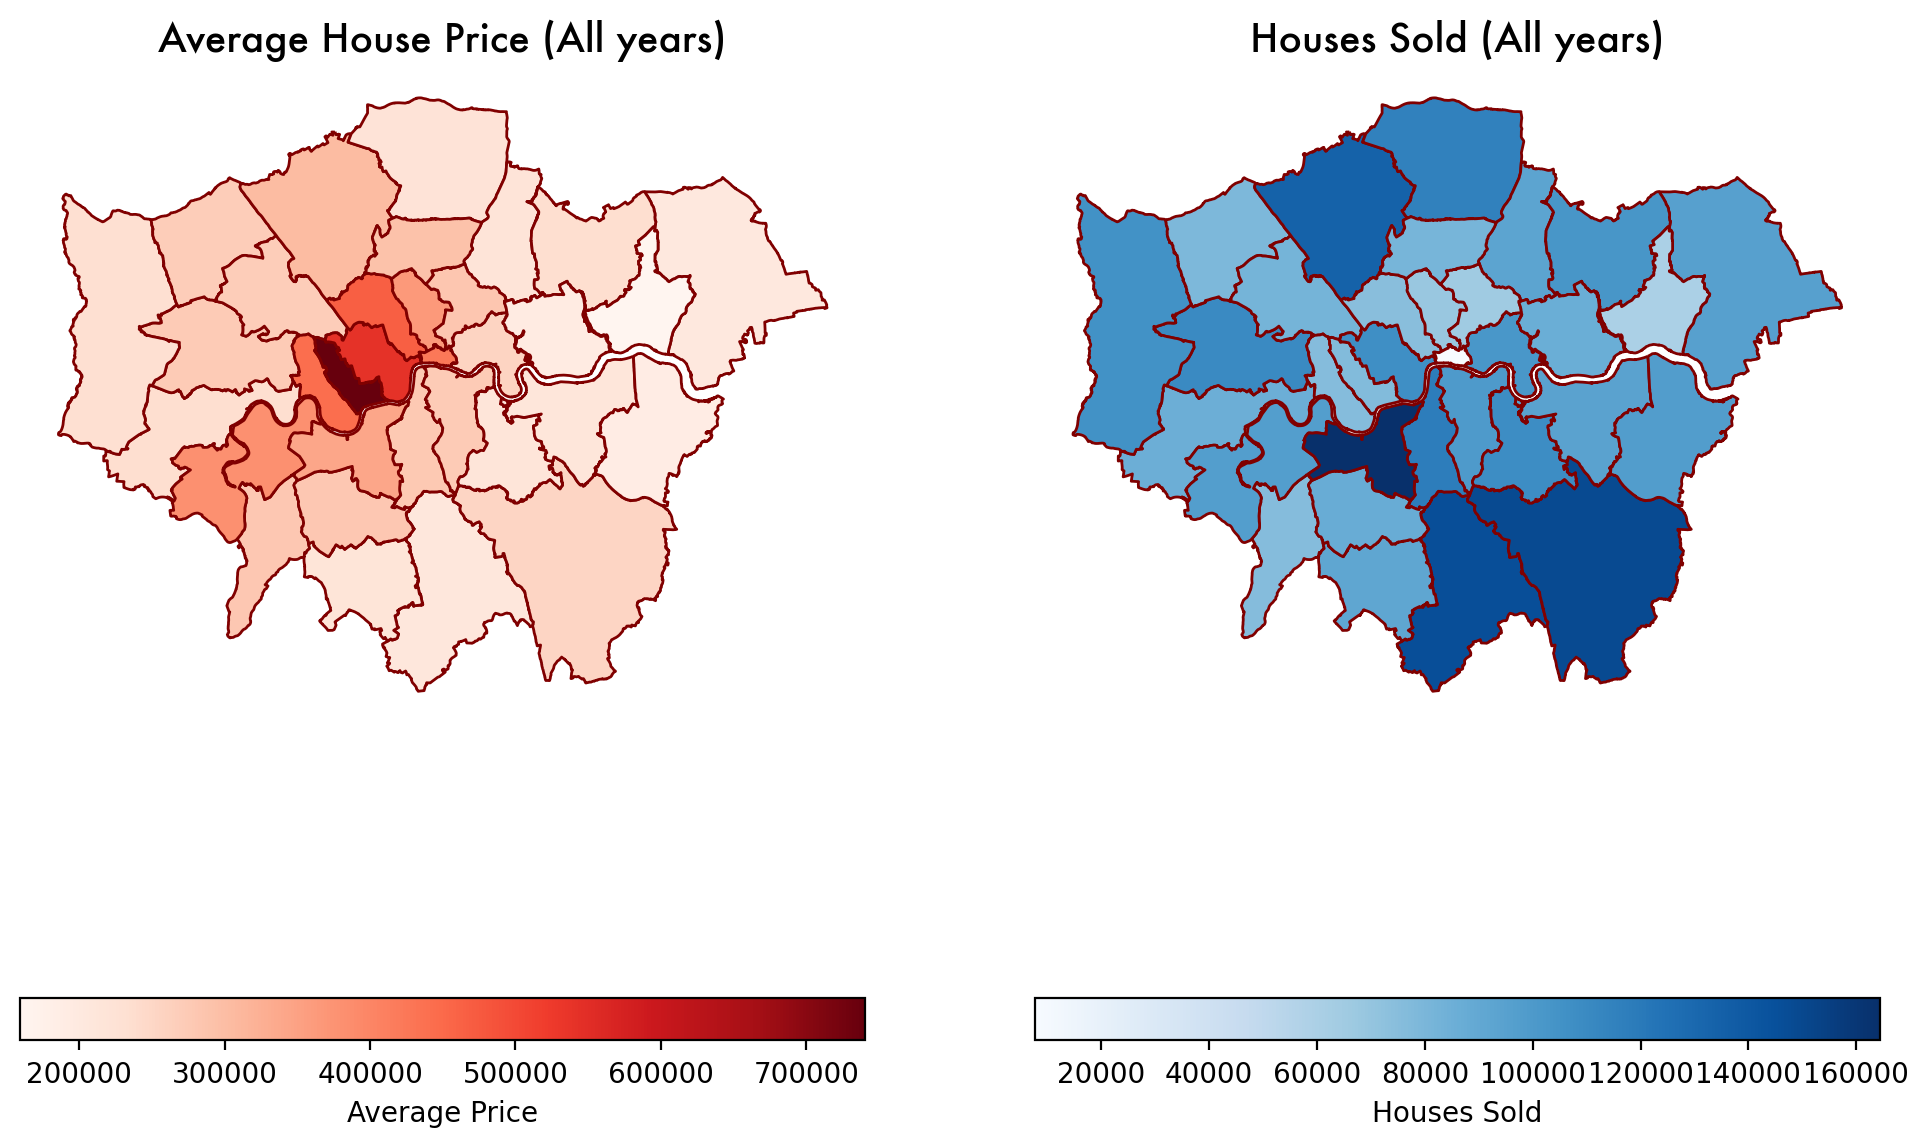

In [51]:
fig, ax = plt.subplots(1, 2, figsize = (12, 12))

london_map.plot(ax = ax[0], column = 'average_price', cmap = 'Reds', edgecolor = 'maroon', legend = True, legend_kwds = {'label': 'Average Price', 'orientation' : 'horizontal'})

london_map.plot(ax = ax[1], column = 'houses_sold', cmap = 'Blues', edgecolor = 'maroon', legend = True, legend_kwds = {'label': 'Houses Sold', 'orientation' : 'horizontal'})

ax[0].axis('off')
ax[0].set_title('Average House Price (All years)', size = font_size, **csfont)
ax[1].axis('off')
ax[1].set_title('Houses Sold (All years)', size = font_size, **csfont);

- We can now see Kensighton and Westminister as the two dark boroughs in the first map. We can roughly say that boroughs **closer** to these two areas are **more expensive**.
- As we hinted earlier, the number of houses sold is probably affected by many factors with one of them being the **total area** of each borough. We can definetely see that larger boroughs have more houses sold.

---

# Factors Affecting Housing

## Preparing the Final Dataset

For this question we need to import the third and final dataset ('**housing_in_london_yearly_variables**') which we are going to merge with the monthly dataset.

In [54]:
london_yearly = pd.read_csv('housing_in_london_yearly_variables.csv', parse_dates = ['date'])
london_yearly = london_yearly[london_yearly['area'].isin(london_boroughs)] # select only London boroughs

print ('This dataset contains {} rows and {} columns.'.format(london_yearly.shape[0], london_yearly.shape[1]))
london_yearly.head()

This dataset contains 693 rows and 12 columns.


,code,area,date,median_salary,life_satisfaction,mean_salary,recycling_pct,population_size,number_of_jobs,area_size,no_of_houses,borough_flag
0,E09000001,city of london,1999-12-01,33020.0,NaN,48922,0,6581.0,NaN,NaN,NaN,1
1,E09000002,barking and dagenham,1999-12-01,21480.0,NaN,23620,3,162444.0,NaN,NaN,NaN,1
2,E09000003,barnet,1999-12-01,19568.0,NaN,23128,8,313469.0,NaN,NaN,NaN,1
3,E09000004,bexley,1999-12-01,18621.0,NaN,21386,18,217458.0,NaN,NaN,NaN,1
4,E09000005,brent,1999-12-01,18532.0,NaN,20911,6,260317.0,NaN,NaN,NaN,1


This dataset has more information for each borough and is ideal for answering the second question. Let's see how many missing values each attrbitutes has:

In [55]:
null_london_yearly = london_yearly.isnull().sum().sort_values(ascending = False)
percent = (london_yearly.isnull().sum()/london_yearly.isnull().count()).sort_values(ascending = False)*100

null_df = pd.concat([null_london_yearly, percent], axis = 1, keys = ['Counts', '%'])
null_df.head(10)

,Counts,%
life_satisfaction,437,63.059163
area_size,99,14.285714
no_of_houses,99,14.285714
number_of_jobs,66,9.523810
recycling_pct,33,4.761905
population_size,33,4.761905
median_salary,10,1.443001
code,0,0.000000
area,0,0.000000
date,0,0.000000


In [ ]:
# import missingno as msno
# msno.matrix(df_y)

It seems that all new attributes have missing values. Pandas' `corr()` function, which we are going to use later, ignores a pairwise correlation if there is a NaN value in one of the observations, so we shouldn't worry about it for now.

'median_salary' is not currently numeric. If we try to convert it to numeric (with the `astype()` method), we'll get an error. That's because some instances contain symbols and need to be replaced first:

In [56]:
london_yearly[~london_yearly['mean_salary'].str.isnumeric()]['mean_salary'].value_counts()

#    7
Name: mean_salary, dtype: int64

In [57]:
london_yearly['mean_salary'] = london_yearly['mean_salary'].replace(['#'], np.NaN)
london_yearly['mean_salary'] = london_yearly['mean_salary'].astype(float)

In [59]:
london_yearly['year'] = london_yearly['date'].dt.year

print ('yearly_variables dataset')
print ('\tFirst date: ', london_yearly['year'].min())
print ('\tFinal date: ', london_yearly['year'].max())

yearly_variables dataset
	First date:  1999
	Final date:  2019


This dataset starts four years later compared to the monthly dataset. Therefore, we need to merge them so that there is no mismatch in the 'year' column:

In [60]:
lnd_m_group = london.groupby(['area', 'year']).mean().reset_index()  # group based on area and year (take mean)
lnd_m_group = lnd_m_group[lnd_m_group['year'] >= 1999]            # select all years after 1999 (included)

print ('monthly_variables dataset')
print ('\tFirst date: ', lnd_m_group['year'].min())
print ('\tFinal date: ', lnd_m_group['year'].max())

monthly_variables dataset
	First date:  1999
	Final date:  2019


In [61]:
lnd_y_group = london_yearly.groupby(['area', 'year']).mean().reset_index() # group it based on area and year
lnd_y_group.head()

,area,year,median_salary,life_satisfaction,mean_salary,population_size,number_of_jobs,area_size,no_of_houses,borough_flag
0,barking and dagenham,1999,21480.0,NaN,23620.0,162444.0,NaN,NaN,NaN,1.0
1,barking and dagenham,2000,22618.0,NaN,24696.0,163893.0,57000.0,NaN,NaN,1.0
2,barking and dagenham,2001,22323.0,NaN,26050.0,165654.0,54000.0,3780.0,68298.0,1.0
3,barking and dagenham,2002,24813.0,NaN,26653.0,166357.0,52000.0,3780.0,68526.0,1.0
4,barking and dagenham,2003,25358.0,NaN,27792.0,166210.0,55000.0,3780.0,68837.0,1.0


The two datasets are ready to be merged:

In [62]:
lnd_total = pd.merge(lnd_y_group, lnd_m_group, on = ['area', 'year'], how = 'left')
lnd_total.drop(['borough_flag_x', 'borough_flag_y'], axis = 1, inplace = True)

lnd_total.head()

,area,year,median_salary,life_satisfaction,mean_salary,population_size,number_of_jobs,area_size,no_of_houses,average_price,houses_sold
0,barking and dagenham,1999,21480.0,NaN,23620.0,162444.0,NaN,NaN,NaN,65320.833333,223.833333
1,barking and dagenham,2000,22618.0,NaN,24696.0,163893.0,57000.0,NaN,NaN,77549.500000,234.416667
2,barking and dagenham,2001,22323.0,NaN,26050.0,165654.0,54000.0,3780.0,68298.0,88664.000000,266.916667
3,barking and dagenham,2002,24813.0,NaN,26653.0,166357.0,52000.0,3780.0,68526.0,112221.916667,287.416667
4,barking and dagenham,2003,25358.0,NaN,27792.0,166210.0,55000.0,3780.0,68837.0,142499.000000,301.250000


## Correlations

In [63]:
corr_table = lnd_total.corr()
corr_table['average_price'].sort_values(ascending = False)

average_price        1.000000
year                 0.640333
median_salary        0.584034
number_of_jobs       0.481682
mean_salary          0.479570
life_satisfaction    0.267131
no_of_houses        -0.059515
population_size     -0.135301
area_size           -0.332420
houses_sold         -0.409190
Name: average_price, dtype: float64

- It doesn't come as a surpise that apart from the year, the average price in London has a **significant positive correlation** with the **median and mean salary** along with the **number of jobs** in a borough. 
- There is **small positive correlation** with **life satisfaction**. More data for this attribute would be useful.
- As we discussed earlier, the most affluent boroughs happen to be small (see map) which explains the **negative correlation** with the **size** of an area. 
- The average price is also affected by the **number of houses sold**, since the former goes up when the later decreases (people sell higher when less houses are sold?).

We can summarise these correlations (along with all pair-wise correlations) with the following heatmap:

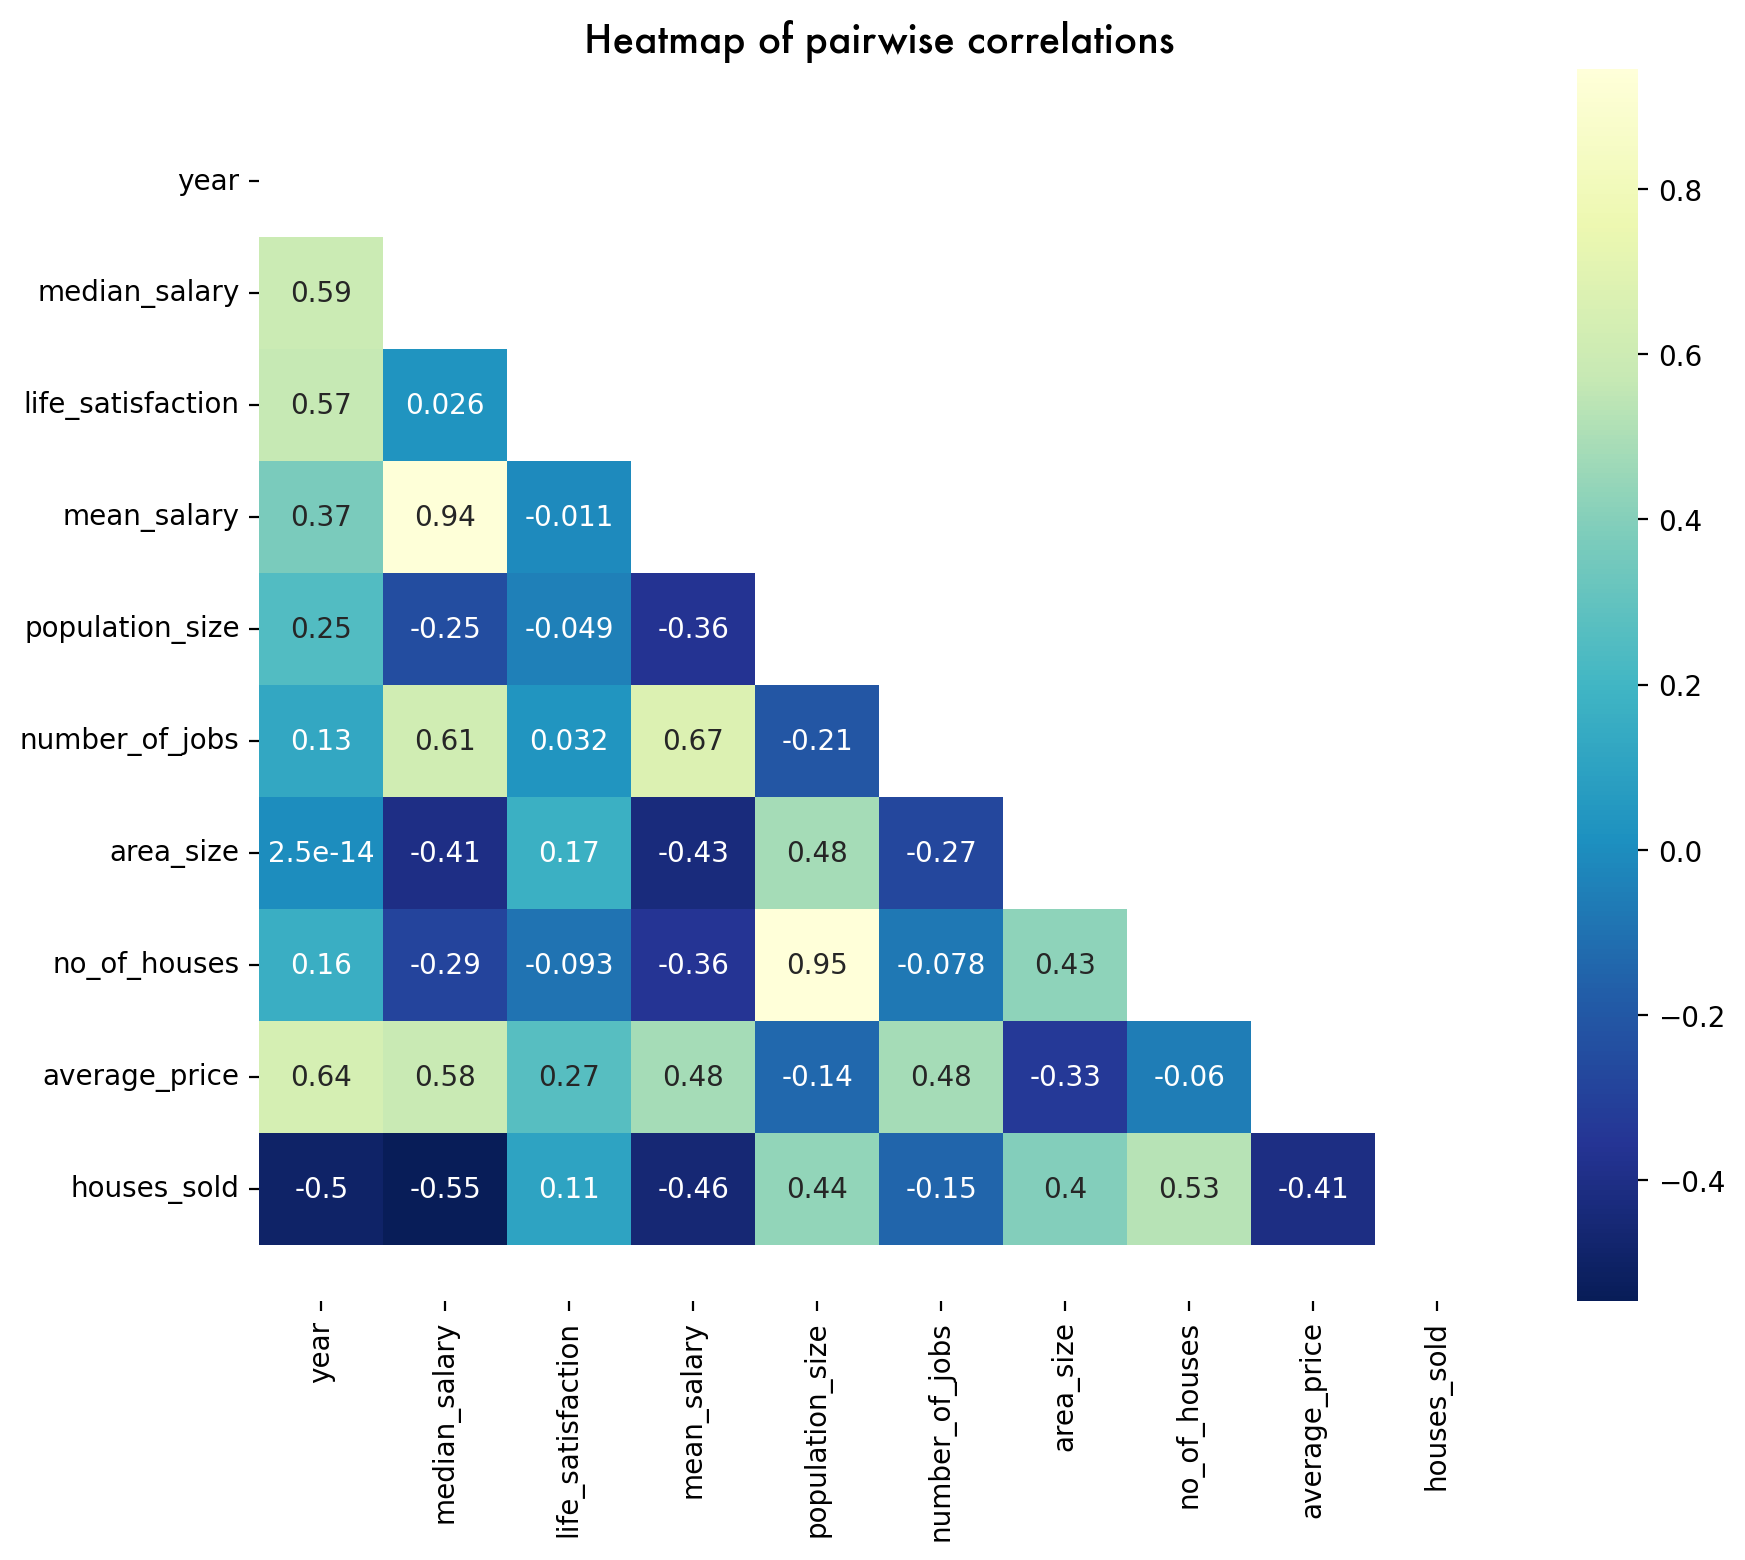

In [65]:
plt.figure(figsize = (10, 8))

mask = np.triu(np.ones_like(corr_table, dtype = np.bool))

ax = sns.heatmap(corr_table, mask = mask, annot = True, cmap = 'YlGnBu_r')
ax.set_title('Heatmap of pairwise correlations', size = font_size, **csfont)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5);

We can see some obvious correlations such as median-mean salary, houses sold-no_of_houses, no_of_houses-population_size, etc.

Lastly, a linear relationship between attributes can be visualised with the `scatter_matrix` method:

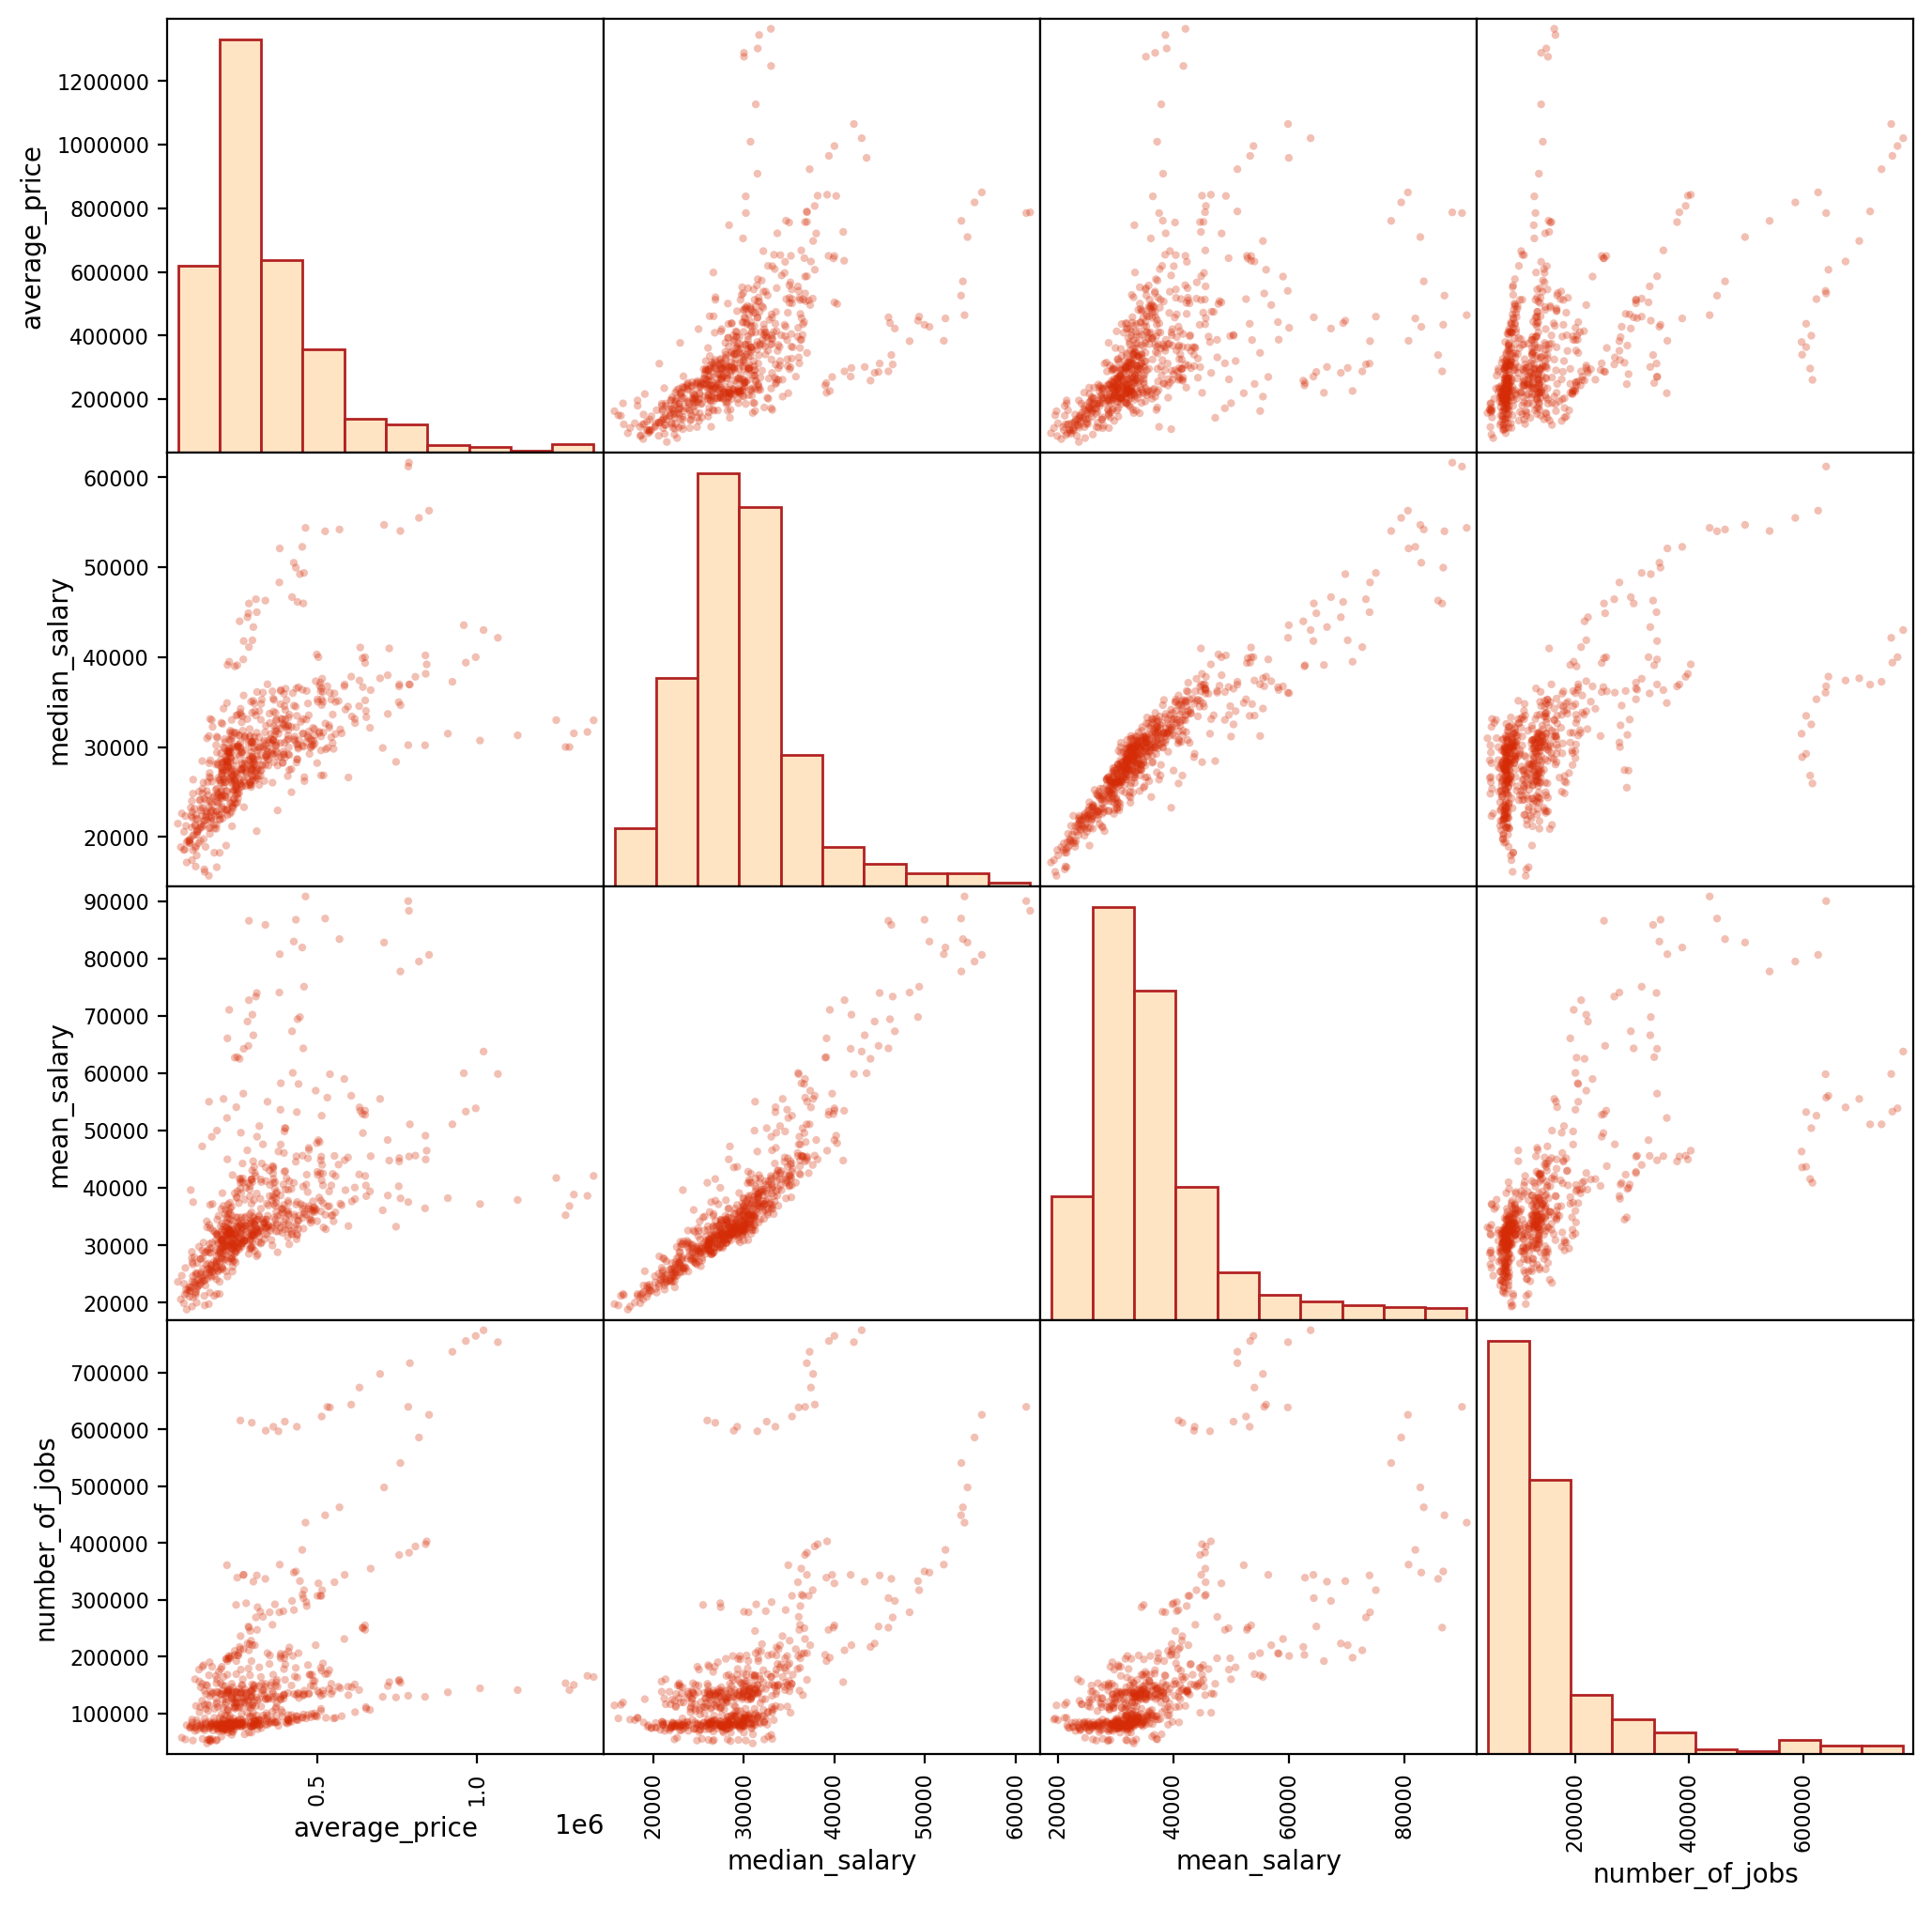

In [66]:
columns = ['average_price', 'median_salary', 'mean_salary', 'number_of_jobs']

scatter_matrix(lnd_total[columns], figsize = (12, 12), color = '#D52B06', alpha = 0.3, 
               hist_kwds = {'color':['bisque'], 'edgecolor': 'firebrick'});

In [68]:
# import libraries

from  sklearn.model_selection import train_test_split 
from sklearn.model_selection import GridSearchCV
from sklearn.utils.validation import check_array

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import lightgbm


from sklearn.metrics import mean_absolute_error 
from sklearn.metrics import mean_squared_error, r2_score  
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import cross_val_score

OSError: dlopen(/Users/thijs/opt/anaconda3/envs/gis_project/lib/python3.8/site-packages/lightgbm/lib_lightgbm.so, 0x0006): Library not loaded: /usr/local/opt/libomp/lib/libomp.dylib
  Referenced from: <D21A7969-4567-3BC7-94ED-6A9E83AE9D78> /Users/thijs/opt/anaconda3/envs/gis_project/lib/python3.8/site-packages/lightgbm/lib_lightgbm.so
  Reason: tried: '/usr/local/opt/libomp/lib/libomp.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/usr/local/opt/libomp/lib/libomp.dylib' (no such file), '/usr/local/opt/libomp/lib/libomp.dylib' (no such file), '/usr/local/lib/libomp.dylib' (no such file), '/usr/lib/libomp.dylib' (no such file, not in dyld cache)

In [ ]:
# Preprocessing data

def preprocessing_data(df = london_monthly, training_size = 0.8):
  # Drop unneccessary features
  df_predict = df.drop(columns =['code','houses_sold','borough_flag'])

  # Extract date feature
  df_predict['year'] = df_predict['date'].apply(lambda x: x.year)
  df_predict['month'] = df_predict['date'].apply(lambda x: x.month)
  df_predict = df_predict.drop(columns =['date'])

  # one hot encoding
  ohe = pd.get_dummies(df_predict['area'], drop_first= True)
  df_predict = pd.concat([df_predict,ohe], axis =1)
  df_predict = df_predict.drop(columns =['area'], axis =1)
 

  # Given x, y 
  x = df_predict.drop(columns = ['average_price'])
  y = df_predict['average_price']


  # Train-test split (train data 80%)
  x_train, x_test, y_train, y_test = train_test_split(x, y, train_size= training_size, shuffle=True, random_state=42)

  # Standard scaling x
  scaler = StandardScaler()
  scaler.fit(x_train)
  x_train = pd.DataFrame(scaler.transform(x_train), index=x_train.index, columns=x_train.columns)
  x_test = pd.DataFrame(scaler.transform(x_test), index=x_test.index, columns=x_test.columns)

  return x_train, x_test, y_train, y_test

x_train, x_test, y_train, y_test = preprocessing_data()


In [ ]:
# K-Nearest Neighbours

knn = KNeighborsRegressor()
parameters = {'n_neighbors' : [2, 3, 5, 7],
               'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'] ,
               }

grid_knn = GridSearchCV(estimator= knn, param_grid = parameters, cv = 3, n_jobs=-1)
grid_knn.fit(x_train, y_train)

# Print Best hyperparameters
print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",grid_knn.best_estimator_)
print("\n The best score across ALL searched params:\n",grid_knn.best_score_)
print("\n The best parameters across ALL searched params:\n",grid_knn.best_params_)

In [ ]:
# LightGBM

lgbm = LGBMRegressor()
parameters = {'boosting_type' : ['gbdt', "dart", 'goss'],
               'learning_rate': [0.01, 0.03, 0.1] ,
               'n_estimators' : [100, 500, 1000] }

grid_lgbm = GridSearchCV(estimator=lgbm, param_grid = parameters, cv = 3, n_jobs=-1)
grid_lgbm.fit(x_train, y_train)

# Print Best hyperparameters
print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",grid_lgbm.best_estimator_)
print("\n The best score across ALL searched params:\n",grid_lgbm.best_score_)
print("\n The best parameters across ALL searched params:\n",grid_lgbm.best_params_)

lgbm_ft = grid_lgbm.best_estimator_
lgbm_ft.fit(x_train, y_train)

predictions = lgbm_ft.predict(x_test)
mse = mean_squared_error(y_test, predictions)
print("MSE:", mse)
rmse = np.sqrt(mse)
print("RMSE:", rmse)
r2 = r2_score(y_test, predictions)
print("R2:", r2)

# Plot predicted vs actual
plt.figure(figsize=(7, 4)) 
plt.scatter(y_test, predictions, color = 'steelblue')
plt.xlabel('Actual Labels')
plt.ylabel('Predicted Labels')
plt.title('LGBM', fontsize= 20)
# overlay the regression line
z = np.polyfit(y_test, predictions, 1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test), color='red')
plt.show()



In [ ]:
# Random forest
from sklearn.model_selection import GridSearchCV

rfm = RandomForestRegressor()
parameters = {    'n_estimators' : [None, 100 , 500, 1000],
                  'max_depth'    : [2, 3, 5, None]
                 }

grid_rfm = GridSearchCV(estimator=rfm, param_grid = parameters, cv = 3, n_jobs=-1)
grid_rfm.fit(x_train, y_train)

print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",grid_rfm.best_estimator_)
print("\n The best score across ALL searched params:\n",grid_rfm.best_score_)
print("\n The best parameters across ALL searched params:\n",grid_rfm.best_params_)

rfm_ft = grid_rfm.best_estimator_
rfm_ft.fit(x_train, y_train)

predictions = rfm_ft.predict(x_test)
mse = mean_squared_error(y_test, predictions)
print("MSE:", mse)
rmse = np.sqrt(mse)
print("RMSE:", rmse)
r2 = r2_score(y_test, predictions)
print("R2:", r2)

# Plot predicted vs actual
plt.figure(figsize=(7, 4)) 
plt.scatter(y_test, predictions, color = 'steelblue')
plt.xlabel('Actual Labels')
plt.ylabel('Predicted Labels')
plt.title('Random Forest', fontsize= 20)
# overlay the regression line
z = np.polyfit(y_test, predictions, 1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test), color='black')
plt.show()

# Conclusions

The main conclusions are the following:

- The average price in **London boroughs** is **higher** compared to the rest of England. It has been **affected** by major financial and political events (such the Recession and Brexit), but has **significantly increased** from 1995 to 2019 (by a factor of 5),

- **Affluent regions** such as Kensighton and Westiminister have the **highest average price**, 

- The number of houses sold **plummeted** after the recession, **streadily increased** until 2016 but then again **dropped** after the referendum, 

- As anyone could predict, the main factor that influences the average price is the **financial prosperity** of the corresponding borough. Higher salaries and more jobs result in higher prices.